In [1]:
%matplotlib inline
import math
import scipy
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

### Data Preparation

In [2]:
# Read data
df = pd.read_csv('../Data/world_happiness_report_2/2017.csv')
df.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [3]:
# Clean data
df = df[['Country', 'Happiness.Score', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.']]

df = df.rename(index=str, columns={'Happiness.Score': 'happiness_score',
                              'Economy..GDP.per.Capita.': 'gdp_per_capita',
                              'Health..Life.Expectancy.': 'life_expectancy',
                              'Trust..Government.Corruption.': 'trust_in_government',
                              'Family': 'family',
                              'Freedom': 'freedom',
                              'Generosity': 'generosity',
                              'Country': 'country'})

df.head()

,country,happiness_score,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government
0,Norway,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964
1,Denmark,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770
2,Iceland,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527
3,Switzerland,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007
4,Finland,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612


In [4]:
# Check for missing values
df.isnull().values.any()

False

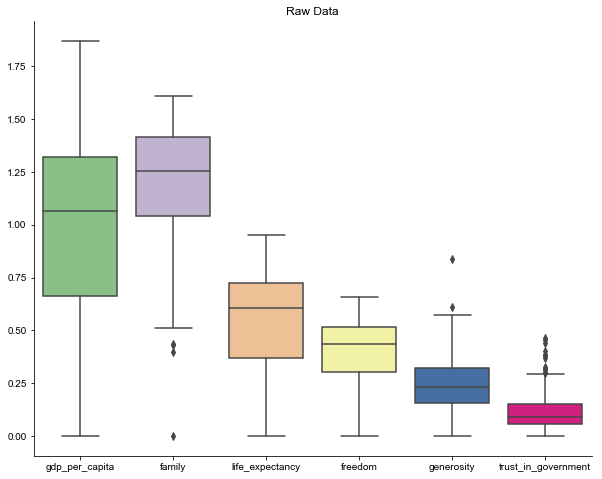

In [5]:
# Plot to see outliers
f, ax = plt.subplots(figsize=(10, 8))
sns.set(style='whitegrid')
sns.despine()

sns.boxplot(data=df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']], palette='Accent')
plt.title('Raw Data')
plt.show()

Although there is some overlap, I think I might still need to normalize the scores before we start delving into the data to check for things like correlation.

In [6]:
norm_data = preprocessing.normalize(df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']])

# Store in new dataframe
norm_df = pd.DataFrame(norm_data, columns=['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government'])

# First need to reset the index for both df
norm_df.index = df.index
norm_df['happiness_score'] = df['happiness_score']
norm_df.head()


,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government,happiness_score
0,0.647416,0.614197,0.319076,0.254496,0.144991,0.126548,7.537
1,0.609754,0.638029,0.326009,0.257498,0.146139,0.164850,7.522
2,0.598311,0.650819,0.336831,0.253431,0.192162,0.062039,7.504
3,0.634153,0.614675,0.347727,0.251262,0.117735,0.148717,7.494
4,0.604672,0.645166,0.338933,0.258842,0.102826,0.160265,7.469


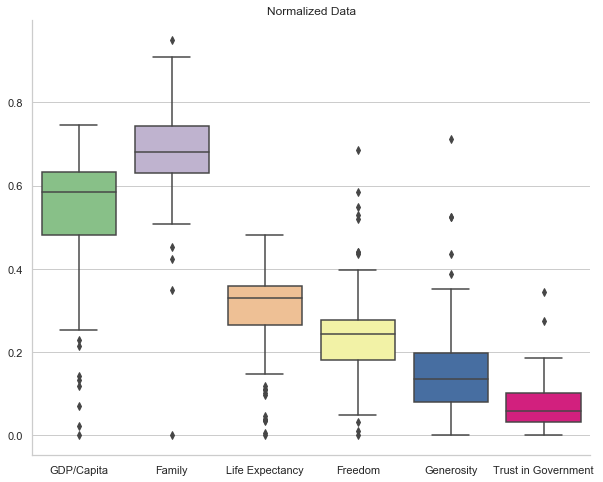

In [7]:
# Let's see the normalized data
f, ax = plt.subplots(figsize=(10, 8))
sns.despine()
sns.set(style='whitegrid')

# Plot the independent variable columns
data = norm_df[['gdp_per_capita', 'family', 'life_expectancy', 'freedom', 'generosity', 'trust_in_government']]

sns.boxplot(data=data, palette='Accent')
plt.title('Normalized Data')
plt.xticks([0, 1, 2, 3, 4, 5], ['GDP/Capita', 'Family', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust in Government'])
plt.show()

In [8]:
# Just for the exercise, let's try standardizing the data
stand_data = preprocessing.scale(df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']])

# Store in new dataframe
stand_df = pd.DataFrame(stand_data, columns=['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government'])

stand_df.index = df.index
stand_df['happiness_score'] = df['happiness_score']
stand_df.head()


,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government,happiness_score
0,1.506188,1.203577,1.038167,1.515836,0.856964,1.903084,7.537
1,1.186518,1.265036,1.020812,1.452859,0.806856,2.739998,7.522
2,1.182345,1.472669,1.194259,1.460590,1.702013,0.300066,7.504
3,1.383442,1.145561,1.298272,1.413155,0.325028,2.406809,7.494
4,1.093985,1.227057,1.091026,1.398978,-0.010426,2.560800,7.469


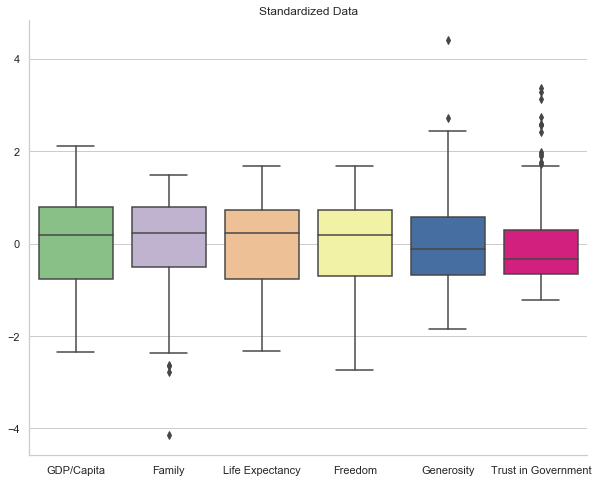

In [9]:
# Plot standardized data
f, ax = plt.subplots(figsize=(10, 8))
sns.despine()
sns.set(style='whitegrid')

data = stand_df[['gdp_per_capita', 'family', 'life_expectancy', 'freedom', 'generosity', 'trust_in_government']]

sns.boxplot(data=data, palette='Accent')
plt.title('Standardized Data')
plt.xticks([0, 1, 2, 3, 4, 5], ['GDP/Capita', 'Family', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust in Government'])
plt.show()

Standardized data looks cleaner with less outliers, so let's move ahead with the X_stand and calculate the correlation between the independent variables.

In [10]:
# Correlation Matrix
X = df[['gdp_per_capita', 'family', 'life_expectancy',
       'freedom', 'generosity', 'trust_in_government']]

corr_mat = X.corr()
display(corr_mat)

,gdp_per_capita,family,life_expectancy,freedom,generosity,trust_in_government
gdp_per_capita,1.000000,0.688296,0.843077,0.369873,-0.019011,0.350944
family,0.688296,1.000000,0.612080,0.424966,0.051693,0.231841
life_expectancy,0.843077,0.612080,1.000000,0.349827,0.063191,0.279752
freedom,0.369873,0.424966,0.349827,1.000000,0.316083,0.499183
generosity,-0.019011,0.051693,0.063191,0.316083,1.000000,0.294159
trust_in_government,0.350944,0.231841,0.279752,0.499183,0.294159,1.000000


It doesn't look like we have to worry too much about redundancy in our data. One interesting correlation is between GDP/Capita and Generosity. There is a very slight negative correlation, meaning that generosity levels stay flat or even decreases with an increase in GDP. Draw whatever conclusion you might from that, and let's move on.

### OLS Regression Model

In [11]:
# Build OLS regression model
X = df[['gdp_per_capita', 'family', 'life_expectancy','freedom', 'generosity', 'trust_in_government']]
Y = df[['happiness_score']]
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# QUESTION: WHAT IS THE CONVENTION WITH x, y, X and Y?

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
# R2 score, Intercept, and coef[0]ficients
r2 = regr.score(X, Y)
intercept = regr.intercept_
coef = regr.coef_

stats = {'R2': r2,
         'α': intercept,
         'β1': coef[0][0],
         'β2': coef[0][1],
         'β3': coef[0][2],
         'β4': coef[0][3],
         'β5': coef[0][4],
         'β6': coef[0][5]}

stats_df = pd.DataFrame(stats, index=['stats'])
display(stats_df)

,R2,α,β1,β2,β3,β4,β5,β6
stats,0.812425,1.743029,0.784433,1.117771,1.28888,1.475715,0.380718,0.826607


In [13]:
# Try the same with normalized data
X_norm = norm_df[['gdp_per_capita', 'family', 'life_expectancy','freedom', 'generosity', 'trust_in_government']]
Y_norm = norm_df['happiness_score'].values.reshape(-1, 1)
regr_norm = linear_model.LinearRegression()
regr_norm.fit(X_norm, Y_norm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
# Calculate R2, intercept and coefficients
r2_norm = regr_norm.score(X_norm, Y_norm)
intercept_norm = regr_norm.intercept_
coef_norm = regr_norm.coef_

stats_norm = {'R2': r2_norm,
              'α': intercept_norm,
              'β1': coef_norm[0][0],
              'β2': coef_norm[0][1],
              'β3': coef_norm[0][2],
              'β4': coef_norm[0][3],
              'β5': coef_norm[0][4],
              'β6': coef_norm[0][5]}

stats_norm_df = pd.DataFrame(stats_norm, index=['stats_norm'])
#stats_df = stats_df.drop(index=['stats_norm']) # drops all previous 'stats_norm' rows
stats_df = stats_df.append(stats_norm_df)
display(stats_df)

,R2,α,β1,β2,β3,β4,β5,β6
stats,0.812425,1.743029,0.784433,1.117771,1.288880,1.475715,0.380718,0.826607
stats_norm,0.405101,-0.751192,5.017828,2.487001,3.095913,2.272231,-0.360201,4.068121


In [15]:
# Try the same with standardized data just for kicks
X_stand = stand_df[['gdp_per_capita', 'family', 'life_expectancy','freedom', 'generosity', 'trust_in_government']]
Y_stand = stand_df[['happiness_score']]
regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand, Y_stand)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [16]:
# Calculate R2, intercept and coefficients
r2_stand = regr_stand.score(X_stand, Y_stand)
intercept_stand = regr_stand.intercept_
coef_stand = regr_stand.coef_

stats_stand = {'R2': r2_stand,
              'α': intercept_stand,
              'β1': coef_stand[0][0],
              'β2': coef_stand[0][1],
              'β3': coef_stand[0][2],
              'β4': coef_stand[0][3],
              'β5': coef_stand[0][4],
              'β6': coef_stand[0][5]}

stats_stand_df = pd.DataFrame(stats_stand, index=['stats_stand'])
#stats_df = stats_df.drop(index=['stats_stand'])
stats_df = stats_df.append(stats_stand_df)
display(stats_df)

,R2,α,β1,β2,β3,β4,β5,β6
stats,0.812425,1.743029,0.784433,1.117771,1.288880,1.475715,0.380718,0.826607
stats_norm,0.405101,-0.751192,5.017828,2.487001,3.095913,2.272231,-0.360201,4.068121
stats_stand,0.812425,5.354019,0.329017,0.320057,0.304571,0.220638,0.051148,0.083762


In [17]:
# Check p-values to see if any of the variables can be excluded without hurting the R2 score.
# We'll use statsmodels for this

formula = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'
formula_norm = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'
formula_stand = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom+generosity+trust_in_government'

lm = smf.ols(formula=formula, data=df).fit()
lm_norm = smf.ols(formula=formula_norm, data=norm_df).fit()
lm_stand = smf.ols(formula=formula_stand, data=stand_df).fit()

# Check for consistency
print('Raw:\n', lm.params)
print('\nNormalized:\n', lm_norm.params)
print('\nStandardized:\n', lm_stand.params)

Raw:
 Intercept              1.743029
gdp_per_capita         0.784433
family                 1.117771
life_expectancy        1.288880
freedom                1.475715
generosity             0.380718
trust_in_government    0.826607
dtype: float64

Normalized:
 Intercept             -0.751192
gdp_per_capita         5.017828
family                 2.487001
life_expectancy        3.095913
freedom                2.272231
generosity            -0.360201
trust_in_government    4.068121
dtype: float64

Standardized:
 Intercept              5.354019
gdp_per_capita         0.329017
family                 0.320057
life_expectancy        0.304571
freedom                0.220638
generosity             0.051148
trust_in_government    0.083762
dtype: float64


In [18]:
# Looking good. Now let's check p-values
print('Raw:\n',lm.pvalues)
print('\nNormalized:\n', lm_norm.pvalues)
print('\nStandardized:\n', lm_stand.pvalues)

Raw:
 Intercept              1.697316e-16
gdp_per_capita         1.848734e-04
family                 1.399572e-07
life_expectancy        9.648650e-05
freedom                2.980926e-05
generosity             2.495240e-01
trust_in_government    8.997508e-02
dtype: float64

Normalized:
 Intercept              6.288828e-01
gdp_per_capita         8.229122e-07
family                 2.712837e-02
life_expectancy        1.484959e-03
freedom                1.898826e-02
generosity             7.325188e-01
trust_in_government    8.611462e-03
dtype: float64

Standardized:
 Intercept              4.359990e-156
gdp_per_capita          1.848734e-04
family                  1.399572e-07
life_expectancy         9.648650e-05
freedom                 2.980926e-05
generosity              2.495240e-01
trust_in_government     8.997508e-02
dtype: float64


We have two variables whose p-scores are higher than 0.05: generosity at 0.25 and trust in government at 0.09. So let's reduce our feature set and retry. We will leave the features as is for normalized dataset as its p-values are all less than 0.05.

In [19]:
formula = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom'
formula_norm = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom'
formula_stand = 'happiness_score ~ gdp_per_capita+family+life_expectancy+freedom'

lm = smf.ols(formula=formula, data=df).fit()
lm_norm = smf.ols(formula=formula_norm, data=norm_df).fit()
lm_stand = smf.ols(formula=formula_stand, data=stand_df).fit()

print('Raw: ', lm.rsquared)
print('Normalized: ', lm_norm.rsquared)
print('Standardized: ', lm_stand.rsquared)

Raw:  0.8056325565086679
Normalized:  0.3762393718557775
Standardized:  0.8056325565086679


#### Raw Data

In [61]:
from sklearn.model_selection import train_test_split

X = df[['gdp_per_capita', 'family', 'life_expectancy','freedom']]
y = df[['happiness_score']]

# New and improved model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [56]:
r2 = regr.score(X_test, y_test)
intercept = regr.intercept_
coef = regr.coef_

stats = {'R2': r2,
         'α': intercept,
         'β1': coef[0][0],
         'β2': coef[0][1],
         'β3': coef[0][2],
         'β4': coef[0][3]}

pd.DataFrame(stats, index=['raw'])

,R2,α,β1,β2,β3,β4
raw,0.820037,1.84012,0.930498,0.984673,1.170318,1.918669


#### Normalized Data

In [64]:
X_norm = norm_df[['gdp_per_capita', 'family', 'life_expectancy','freedom']]
y_norm = norm_df[['happiness_score']]

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=20)

regr_norm = linear_model.LinearRegression()
regr_norm.fit(X_norm_train, y_norm_train)

r2_norm = regr_norm.score(X_norm_test, y_norm_test)
intercept_norm = regr_norm.intercept_
coef_norm = regr_norm.coef_

stats_norm = {'R2': r2_norm,
              'α': intercept_norm,
              'β1': coef_norm[0][0],
              'β2': coef_norm[0][1],
              'β3': coef_norm[0][2],
              'β4': coef_norm[0][3]}

pd.DataFrame(stats_norm, index=['normalized'])


,R2,α,β1,β2,β3,β4
normalized,0.165448,-2.938375,6.073798,4.46606,3.961222,3.369877


#### Standardized Data

In [65]:
X_stand = stand_df[['gdp_per_capita', 'family', 'life_expectancy','freedom']]
y_stand = stand_df[['happiness_score']]

X_stand_train, X_stand_test, y_stand_train, y_stand_test = train_test_split(X_stand, y_stand, test_size=0.2, random_state=20)

regr_stand = linear_model.LinearRegression()
regr_stand.fit(X_stand_train, y_stand_train)

r2_stand = regr_stand.score(X_stand_test, y_stand_test)
intercept_stand = regr_stand.intercept_
coef_stand = regr_stand.coef_

stats_stand = {'R2': r2_stand,
              'α': intercept_stand,
              'β1': coef_stand[0][0],
              'β2': coef_stand[0][1],
              'β3': coef_stand[0][2],
              'β4': coef_stand[0][3]}

pd.DataFrame(stats_stand, index=['standardized'])


,R2,α,β1,β2,β3,β4
standardized,0.820037,5.356642,0.390282,0.281946,0.276554,0.286865


Let's use the model built with normalized data and test it out on data from 2015 and 2016 to see if the model maintains its accuracy.

In [66]:
# Read data
df_2015 = pd.read_csv('../Data/world_happiness_report_2/2015.csv')
df_2016 = pd.read_csv('../Data/world_happiness_report_2/2016.csv')
#print(data_2015.columns)
#print(data_2016.columns)

# Clean data
df_2015 = df_2015[['Happiness Score', 'Economy (GDP per Capita)', 'Family','Health (Life Expectancy)', 'Freedom']]
df_2016 = df_2016[['Happiness Score', 'Economy (GDP per Capita)', 'Family','Health (Life Expectancy)', 'Freedom']]

# Rename columns
df_2015 = df_2015.rename(index=str, columns={'Happiness Score': 'happiness_score',
                              'Economy (GDP per Capita)': 'gdp_per_capita',
                              'Health (Life Expectancy)': 'life_expectancy',
                              'Family': 'family',
                              'Freedom': 'freedom'})
df_2016 = df_2016.rename(index=str, columns={'Happiness Score': 'happiness_score',
                              'Economy (GDP per Capita)': 'gdp_per_capita',
                              'Health (Life Expectancy)': 'life_expectancy',
                              'Family': 'family',
                              'Freedom': 'freedom'})

df_2015.head()

,happiness_score,gdp_per_capita,family,life_expectancy,freedom
0,7.587,1.39651,1.34951,0.94143,0.66557
1,7.561,1.30232,1.40223,0.94784,0.62877
2,7.527,1.32548,1.36058,0.87464,0.64938
3,7.522,1.45900,1.33095,0.88521,0.66973
4,7.427,1.32629,1.32261,0.90563,0.63297


In [68]:
# Predict raw data
X_2015 = df_2015[['gdp_per_capita', 'family', 'life_expectancy','freedom']]
X_2016 = df_2016[['gdp_per_capita', 'family', 'life_expectancy','freedom']]
y_2015 = df_2015[['happiness_score']]
y_2016 = df_2016[['happiness_score']]

pred_2015 = regr.predict(X_2015)
pred_2016 = regr.predict(X_2016)

# Get R2 score
print('2015 R2: ', regr.score(X_2015, y_2015))
print('2016 R2: ', regr.score(X_2016, y_2016))

2015 R2:  0.7305694403663192
2016 R2:  0.5788866674902227


In [69]:
# normalize data
norm_2015 = preprocessing.normalize(df_2015[['gdp_per_capita', 'family', 'life_expectancy','freedom']])
norm_2016 = preprocessing.normalize(df_2016[['gdp_per_capita', 'family', 'life_expectancy','freedom']])

X_norm_2015 = pd.DataFrame(norm_2015, columns=['gdp_per_capita', 'family', 'life_expectancy', 'freedom'])
X_norm_2016 = pd.DataFrame(norm_2016, columns=['gdp_per_capita', 'family', 'life_expectancy', 'freedom'])
    
# Predict values
norm_pred_2015 = regr_norm.predict(X_norm_2015)
norm_pred_2016 = regr_norm.predict(X_norm_2016)

# Get r2 score
print('2015 R2 Normalized: ', regr_norm.score(X_norm_2015, y_2015))
print('2016 R2 Normalized: ', regr_norm.score(X_norm_2016, y_2016))


2015 R2 Normalized:  0.2347105305666695
2016 R2 Normalized:  0.12815580757856315


In [70]:
# standardize data
stand_2015 = preprocessing.scale(df_2015[['gdp_per_capita', 'family', 'life_expectancy','freedom']])
stand_2016 = preprocessing.scale(df_2016[['gdp_per_capita', 'family', 'life_expectancy','freedom']])

X_stand_2015 = pd.DataFrame(stand_2015, columns=['gdp_per_capita', 'family', 'life_expectancy', 'freedom'])
X_stand_2016 = pd.DataFrame(stand_2016, columns=['gdp_per_capita', 'family', 'life_expectancy', 'freedom'])

# Predict values
stand_pred_2015 = regr_stand.predict(X_stand_2015)
stand_pred_2016 = regr_stand.predict(X_stand_2016)

# Add predictions to dataframe
df_2015['ols_pred'] = stand_pred_2015
df_2016['ols_pred'] = stand_pred_2016

# Get r2 score
print('2015 R2 Standardized: ', regr_stand.score(X_stand_2015, y_2015))
print('2016 R2 Standardized: ', regr_stand.score(X_stand_2016, y_2016))

# Calculate error
from sklearn.metrics import mean_squared_error

mse_ols_2015 = mean_squared_error(stand_pred_2015, y_2015)
mse_ols_2016 = mean_squared_error(stand_pred_2016, y_2016)

print('2015 MSE: ', mse_ols_2015)
print('2016 MSE: ', mse_ols_2016)

2015 R2 Standardized:  0.7661870156967232
2016 R2 Standardized:  0.7792265784740144
2015 MSE:  0.30459996716577975
2016 MSE:  0.2859272772758822


I'd say that's pretty good. Both 2015 and 2016 scored bit below the training set. Our ols regression model seems to be overfitting by a small margin. Now let's see how KNN model does.

### KNN Regression

In [75]:
from sklearn.model_selection import train_test_split

# Unweighted
X = df[['gdp_per_capita', 'family', 'life_expectancy', 'freedom']]
y = df[['happiness_score']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

score = knn.score(X_test, y_test)
print("Unweighted Model Accuracy: ", score)

(124, 4) (31, 4) (124, 1) (31, 1)
Unweighted Model Accuracy:  0.7756549590644327


In [77]:
# Weighted
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w.fit(X_train, y_train)

score_w = knn_w.score(X_test, y_test)

print("Weighted Model Accuracy: ", score_w)

Weighted Model Accuracy:  0.7823853461676713


In [76]:
# Test with 2016 data
score_2015 = knn.score(X_2015, y_2015)
score_2016 = knn.score(X_2016, y_2016)
print('2015 R2: ', score_2015)
print('2016 R2: ', score_2016)

score_w_2015 = knn_w.score(X_2015, y_2015)
score_w_2016 = knn_w.score(X_2016, y_2016)
print('2015 Weighted R2: ', score_w_2015)
print('2016 Weighted R2: ', score_w_2016)


2015 R2:  0.6065232452988891
2016 R2:  0.5140820644553308
2015 Weighted R2:  0.6031612187796968
2016 Weighted R2:  0.5089515377631622


In [78]:
# Normalized
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=20)
print(X_norm_train.shape, X_norm_test.shape, y_norm_train.shape, y_norm_test.shape)

knn_w_norm = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w_norm.fit(X_norm_train, y_norm_train)

score = knn_w_norm.score(X_norm_test, y_norm_test)
print("Model Accuracy Normalized: %0.2f" % score)

score_norm_2015 = knn_w_norm.score(X_norm_2015, y_2015)
print('2015 Accuracy Normalized: %0.2f' % score_norm_2015)

score_norm_2016 = knn_w_norm.score(X_norm_2016, y_2016)
print('2016 Accuracy Normalized: %0.2f' % score_norm_2016)


(124, 4) (31, 4) (124, 1) (31, 1)
Model Accuracy Normalized: 0.49
2015 Accuracy Normalized: 0.40
2016 Accuracy Normalized: 0.28


In [96]:
# Standardized
X_stand_train, X_stand_test, y_stand_train, y_stand_test = train_test_split(X_stand, y_stand, test_size=0.2, random_state=20)

print(X_stand_train.shape, X_stand_test.shape, y_stand_train.shape, y_stand_test.shape)

knn_w_stand = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w_stand.fit(X_stand_train, y_stand_train)

# Make predictions
knn_predict_2015 = knn_w_stand.predict(X_stand_2015)
knn_predict_2016 = knn_w_stand.predict(X_stand_2016)

# Add prediction columns to dataframe
df_2015['knn_pred'] = knn_predict_2015
df_2016['knn_pred'] = knn_predict_2016

# Calculate error
knn_mse_2015 = mean_squared_error(knn_predict_2015, y_2015)
knn_mse_2016 = mean_squared_error(knn_predict_2016, y_2016)

# Display scores
score = knn_w_stand.score(X_stand_test, y_stand_test)
print("Model Accuracy: %0.2f" % score)

score_norm_2015 = knn_w_stand.score(X_stand_2015, y_2015)
print('2015 Accuracy Normalized: %0.2f' % score_norm_2015)
print('2015 MSE: ', knn_mse_2015)

score_norm_2016 = knn_w_stand.score(X_stand_2016, y_2016)
print('2016 Accuracy Normalized: %0.2f' % score_norm_2016)
print('2016 MSE: ', knn_mse_2016)

(124, 4) (31, 4) (124, 1) (31, 1)
Model Accuracy: 0.75
2015 Accuracy Normalized: 0.81
2015 MSE:  0.24169061748302414
2016 Accuracy Normalized: 0.88
2016 MSE:  0.15586213331754936


In [82]:
display(df_2015.head())
display(df_2016.head())


,happiness_score,gdp_per_capita,family,life_expectancy,freedom,ols_pred,knn_pred
0,7.587,1.39651,1.34951,0.94143,0.66557,7.065341,7.369340
1,7.561,1.30232,1.40223,0.94784,0.62877,6.965529,7.224438
2,7.527,1.32548,1.36058,0.87464,0.64938,6.901936,7.140407
3,7.522,1.45900,1.33095,0.88521,0.66973,7.051577,7.430360
4,7.427,1.32629,1.32261,0.90563,0.63297,6.866752,7.102573


,happiness_score,gdp_per_capita,family,life_expectancy,freedom,ols_pred,knn_pred
0,7.526,1.44178,1.16374,0.79504,0.57941,6.911562,7.140340
1,7.509,1.52733,1.14524,0.86303,0.58557,7.067554,7.376249
2,7.501,1.42666,1.18326,0.86733,0.56624,6.979315,7.224356
3,7.498,1.57744,1.12690,0.79579,0.59609,7.035123,7.383206
4,7.413,1.40598,1.13464,0.81091,0.57104,6.849372,6.629426


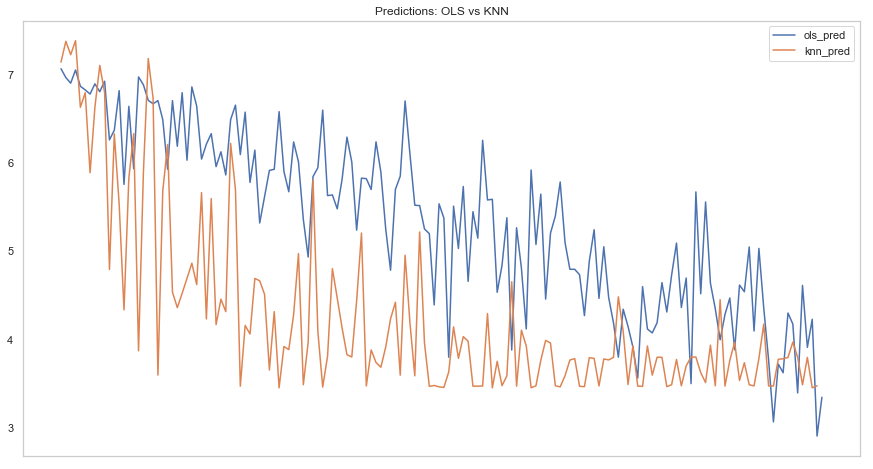

In [94]:
f, ax = plt.subplots(figsize=(15, 8))

ax.grid(False)  # Hide grid lines
ax.set_xticklabels([])   #hide xtick labels

plt.plot(df_2015['ols_pred'])
plt.plot(df_2016['knn_pred'])
plt.title('Predictions: OLS vs KNN')

plt.legend()

### Summary

For this challenge I looked at the world happiness score for the years 2016 and 2017. Both the OLS regression model and KNN regression model did reasonably well in predicting the happiness score. Ordinary Least Squares regression tested to 78% accuracy while the weighted KNN model did better at 88% accuracy for predicting 2016 data. The mean squared errors were also lower for the weighted KNN model. 

The plot above shows the predictions made by both models. The OLS model consistently scored higher than the KNN model incorrectly. It also seems that ols predictions show bigger but more consistent variance where the KNN model starts out with very large variances in the beginning of the dataset but settles down towards the latter half of the dataset. This could be the result of setting the number of neighbors at 5. For larger data sets, KNN would perform even better since we can have more input in making a prediction. In this particular case, the difference between the weighted and unweighted model was insiginificant meaning that the neighbors were nearly equidistant from the test point. 

Also shown in the plot is how the two different models make predicitions. Since the ols model is based on a formula, any y value is theoretically possible for varying values of x whether that type of value exists in the training data or not. However, with the knn model, it is apparent that there is a limit to the predictions because the predictions rely on neighboring data points. KNN  models will not be able to make 

